In [ ]:
purpose: analyze the output from Daniel's TWAS pipeline from TWAS (as of 20 June 2024) for all tissues- for determining whether they can be used for tsem

# set-up

In [298]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import statsmodels.stats.multitest
import numpy as np

In [71]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')

In [72]:
from rca_functions import manhattan

In [73]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [259]:
IBM=['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
colour_dict={
    'ext':IBM[1],
    'ext_alt':IBM[0],
    'loco':IBM[4],
    'loco_alt':IBM[3],
    'shared':IBM[2],
    'other':'#CCCCCC',
    'smkinit_pc1':IBM[1],
    'smkinit_pc1_alt':IBM[0],
    'cigday_pc1':IBM[2],
    'cigday_pc1_alt':'#930741'
}

In [56]:
loco_dir='loco_twas_dan/'

In [239]:
#downloaded from ensembl BioMart on 9 July 2024 for mRatBN7.2
gene_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.gene_map.gtf.gz',compression='gzip',sep='\t')
transcript_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.transcript_map.gtf.gz',compression='gzip',sep='\t')
#downloaded from ensembl- doesn't have gene symbol/transcript name, but does have other info that may be interesting
feat_meta_tbl=pd.read_csv(loco_dir+'Rattus_norvegicus.mRatBN7.2.112.gtf.gz',compression='gzip',skiprows=5,sep='\t',header=None)
feat_meta_tbl.columns=['seqname','source','feature','start','end','score','strand','frame','attribute']
#locomotor activity TWAS calculated by FUSION by Dan Munroe
tbl=pd.read_csv(loco_dir+'regressedlr_combined_locomotor.dat',sep='\t')
tbl['TISSUE']=[s.split('.')[1] for s in tbl.PANEL]
tbl['TYPE_MOD']=[s.split('.')[2] for s in tbl.PANEL]

/tmp/ipykernel_3545894/1650281201.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  feat_meta_tbl=pd.read_csv(loco_dir+'Rattus_norvegicus.mRatBN7.2.112.gtf.gz',compression='gzip',skiprows=5,sep='\t',header=None)


# functions

In [194]:
def extract_IDs(annot, type=None):
    if (type=='gene'):
        #print('returning ENSRNOG')
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOG')]
        if len(ls)>0:
            return(ls[0])
    elif (type=='transcript'):
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOT')]
        if len(ls)>0:
            return(ls[0])
    else:
        return [x for x in re.split('[:.]', annot) if x.startswith('ENSR')]

# format trascript table

In [240]:
tbl['ID_ls']=tbl['ID'].apply(extract_IDs)
tbl['gene_id']=tbl['ID'].apply(extract_IDs,type='gene')
tbl['tran_id']=tbl['ID'].apply(extract_IDs,type='transcript')

In [241]:
#add in gene name
t=tbl.merge(gene_tbl[['Gene stable ID','Gene name']], left_on='gene_id',right_on='Gene stable ID',how='left').drop('Gene stable ID', axis=1)
t=t.merge(transcript_tbl[['Transcript stable ID','Transcript name']], left_on='tran_id',right_on='Transcript stable ID',how='left').drop('Transcript stable ID', axis=1)

In [197]:
pd.Series(list(map(len, tbl['ID_ls']))).describe()
#there's only max 2 IDs- transcript and gene

count    150018.000000
mean          1.262788
std           0.440150
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
dtype: float64

In [265]:
#tissues assayed
for (k in set(t.TISSUE)):
    t_sub=t[(t.TISSUE=='Brain')&(~t['TWAS.P'].isna())].reset_index()
brain['TWAS.Q']=statsmodels.stats.multitest.fdrcorrection(brain['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

{'Adipose',
 'BLA',
 'Brain',
 'Eye',
 'IL',
 'LHb',
 'Liver',
 'NAcc',
 'NAcc2',
 'OFC',
 'PL',
 'PL2'}

In [ ]:
'BLA':'Basolateral amygdala',
'Brain':'Brain hemisphere',
'IL':'Infralimbic cortex',
'LHb':'Lateral habenula',
'NAcc':'Nucleus accumbens core',
'NAcc2':'Nucleus accumbens core 2',
'OFC':'Orbitofrontal cortex',
'PL':'Prelimbic cortex',
'PL2':'Prelimbic cortex 2',
'Adipose':'Adipose',
'Eye':'Eye',
'Liver':'Liver',

In [248]:
#types of protein modifications assayed
set(tbl.TYPE_MOD)

{'alt_TSS', 'alt_polyA', 'expression', 'isoforms', 'splicing', 'stability'}

In [284]:
len(brain)

25746

# analyze TWAS output- brain only

In [286]:
brain=t[(t.TISSUE=='Brain')&(~t['TWAS.P'].isna())].reset_index()
brain['TWAS.Q']=statsmodels.stats.multitest.fdrcorrection(brain['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]

In [292]:
max(brain[brain['TWAS.Q']<0.05]['TWAS.P'])

0.0010946717156678

In [301]:
max(brain[brain['TWAS.P']<0.05/len(brain)]['TWAS.P'])

1.53767732300906e-06

In [253]:
brain.columns

Index(['PANEL', 'FILE', 'ID', 'CHR', 'P0', 'P1', 'HSQ', 'BEST.GWAS.ID',
       'BEST.GWAS.Z', 'EQTL.ID', 'EQTL.R2', 'EQTL.Z', 'EQTL.GWAS.Z', 'NSNP',
       'NWGT', 'MODEL', 'MODELCV.R2', 'MODELCV.PV', 'TWAS.Z', 'TWAS.P',
       'COLOC.PP0', 'COLOC.PP1', 'COLOC.PP2', 'COLOC.PP3', 'COLOC.PP4',
       'TISSUE', 'TYPE_MOD', 'ID_ls', 'gene_id', 'tran_id', 'Gene name',
       'Transcript name'],
      dtype='object')

In [254]:
save_fig=False

In [272]:
type(brain['TWAS.P'][0])

numpy.float64

In [304]:
cutoff=-np.log10(max(brain[brain['TWAS.Q']<0.05]['TWAS.P']))
cutoff2=-np.log10(max(brain[brain['TWAS.P']<0.05/len(brain)]['TWAS.P']))

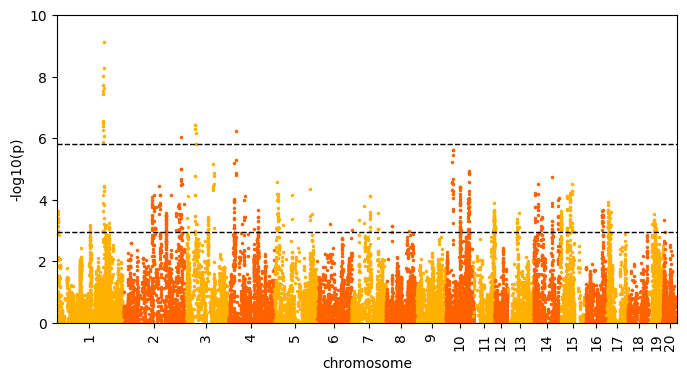

In [308]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
k='loco'
manhattan(pval=brain['TWAS.P'],pos=brain['P0'],chr=brain['CHR'],label='',
                    cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[k], colour_dict[k+'_alt']],
                    lines_widths = [1,1], lines_styles = ["--","--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+str(cutoff)+'_'+k+'_magma'+'.png',dpi=600,bbox_inches='tight')